# 📊 Desafío Bunker DB - Data Scientist

**Autor:** Nicolas Caricati
**Objetivo:** Análisis exploratorio y modelado predictivo para estimar 'likes' en publicaciones de Facebook.

---

## 1. Configuración e Importación

In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge

!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from xgboost import XGBRegressor

from pyparsing import col




# Configuración visual
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [232]:
# Cargar datos
path = '/content/drive/MyDrive/Facebook Likes/Facebook Metrics of Cosmetic Brand.csv'
try:
    df = pd.read_csv(path, sep=',',index_col=0)
    print("Dataset cargado correctamente.")

except FileNotFoundError:
    print(f"No se encuentra '{path}'. Asegúrate de subir el archivo de Kaggle.")

Dataset cargado correctamente.


## 2. Análisis Exploratorio (EDA)

#### 2.1 Caracteristicas grales del dataset

In [233]:
# Información general
print(f"Dimensiones: {df.shape}")
df.info()

Dimensiones: (500, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    flo

In [234]:
df.describe().round(0)

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
count,500.0,500.0,500.0,500.0,500.0,499.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,499.0,496.0,500.0
mean,123194.0,2.0,7.0,4.0,8.0,0.0,13903.0,29586.0,920.0,799.0,1415.0,16766.0,6585.0,610.0,7.0,178.0,27.0,212.0
std,16273.0,1.0,3.0,2.0,4.0,0.0,22741.0,76803.0,985.0,883.0,2001.0,59791.0,7682.0,613.0,21.0,323.0,43.0,380.0
min,81370.0,1.0,1.0,1.0,1.0,0.0,238.0,570.0,9.0,9.0,9.0,567.0,236.0,9.0,0.0,0.0,0.0,0.0
25%,112676.0,1.0,4.0,2.0,3.0,0.0,3315.0,5695.0,394.0,332.0,509.0,3970.0,2182.0,291.0,1.0,56.0,10.0,71.0
50%,129600.0,2.0,7.0,4.0,9.0,0.0,5281.0,9051.0,626.0,552.0,851.0,6256.0,3417.0,412.0,3.0,101.0,19.0,124.0
75%,136393.0,3.0,10.0,6.0,11.0,1.0,13168.0,22086.0,1062.0,956.0,1463.0,14860.0,7989.0,656.0,7.0,188.0,32.0,228.0
max,139441.0,3.0,12.0,7.0,23.0,1.0,180480.0,1110282.0,11452.0,11328.0,19779.0,1107833.0,51456.0,4376.0,372.0,5172.0,790.0,6334.0


In [235]:
# Conteo de registros por tipo de publicación
# df['Type'].value_counts()




In [236]:
# --- Exploración de NAs ---
# Conteo total de valores nulos por columna
na_counts = df.isna().sum()

print("Valores nulos por columna:")
print(na_counts[na_counts > 0])

# Porcentaje de NAs respecto al total
na_percent = (df.isna().sum() / len(df)) * 100
print("\n Porcentaje de NAs por columna:")
print(na_percent[na_percent > 0].round(2))

Valores nulos por columna:
Paid     1
like     1
share    4
dtype: int64

 Porcentaje de NAs por columna:
Paid     0.2
like     0.2
share    0.8
dtype: float64


#### 2.2 Variable Target

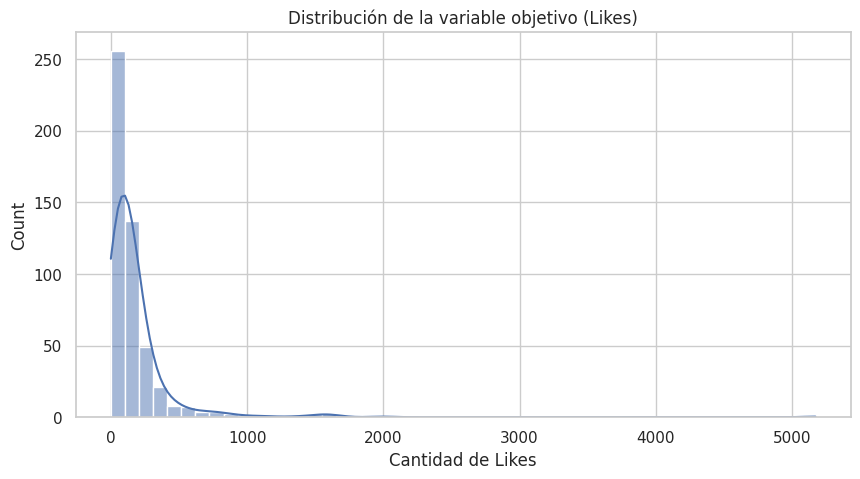

Estadísticas de Likes:
count     499.00
mean      177.95
std       323.40
min         0.00
25%        56.50
50%       101.00
75%       187.50
max      5172.00
Name: like, dtype: float64


In [237]:
# 2. Análisis del Target (Likes)
plt.figure(figsize=(10, 5))
sns.histplot(df['like'], bins=50, kde=True)
plt.title('Distribución de la variable objetivo (Likes)')
plt.xlabel('Cantidad de Likes')
plt.show()

print("Estadísticas de Likes:")
print(df['like'].describe().round(2))

Número de outliers (IQR): 40
Rango normal: [-140.00, 384.00]
Número de outliers (Z-score > 3): 9


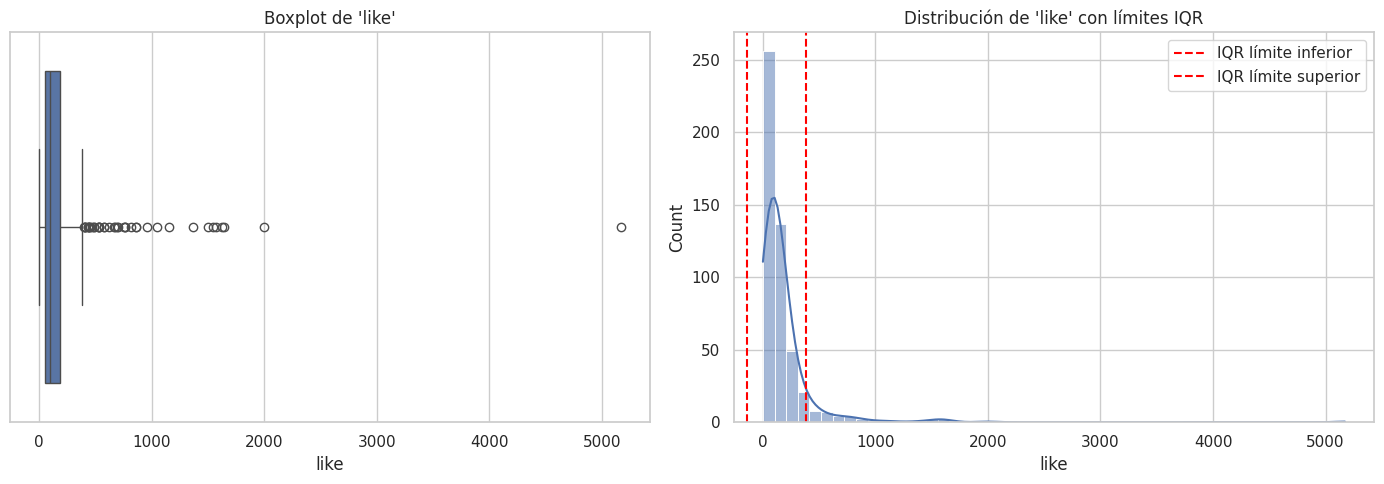

In [238]:
# --- Variable a analizar ---
likes = df['like']

# 1. Método IQR (Interquartile Range)
Q1 = likes.quantile(0.25)
Q3 = likes.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = likes[(likes < lower_bound) | (likes > upper_bound)]

print(f"Número de outliers (IQR): {len(outliers_iqr)}")
print(f"Rango normal: [{lower_bound:.2f}, {upper_bound:.2f}]")

# 2. Método Z-score
z_scores = (likes - likes.mean()) / likes.std()
outliers_z = likes[np.abs(z_scores) > 3]

print(f"Número de outliers (Z-score > 3): {len(outliers_z)}")

# 3. Visualización
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(x=likes)
plt.title("Boxplot de 'like'")

plt.subplot(1,2,2)
sns.histplot(likes, bins=50, kde=True)
plt.axvline(lower_bound, color='red', linestyle='--', label='IQR límite inferior')
plt.axvline(upper_bound, color='red', linestyle='--', label='IQR límite superior')
plt.legend()
plt.title("Distribución de 'like' con límites IQR")

plt.tight_layout()
plt.show()


##### 2. Features Categoricos

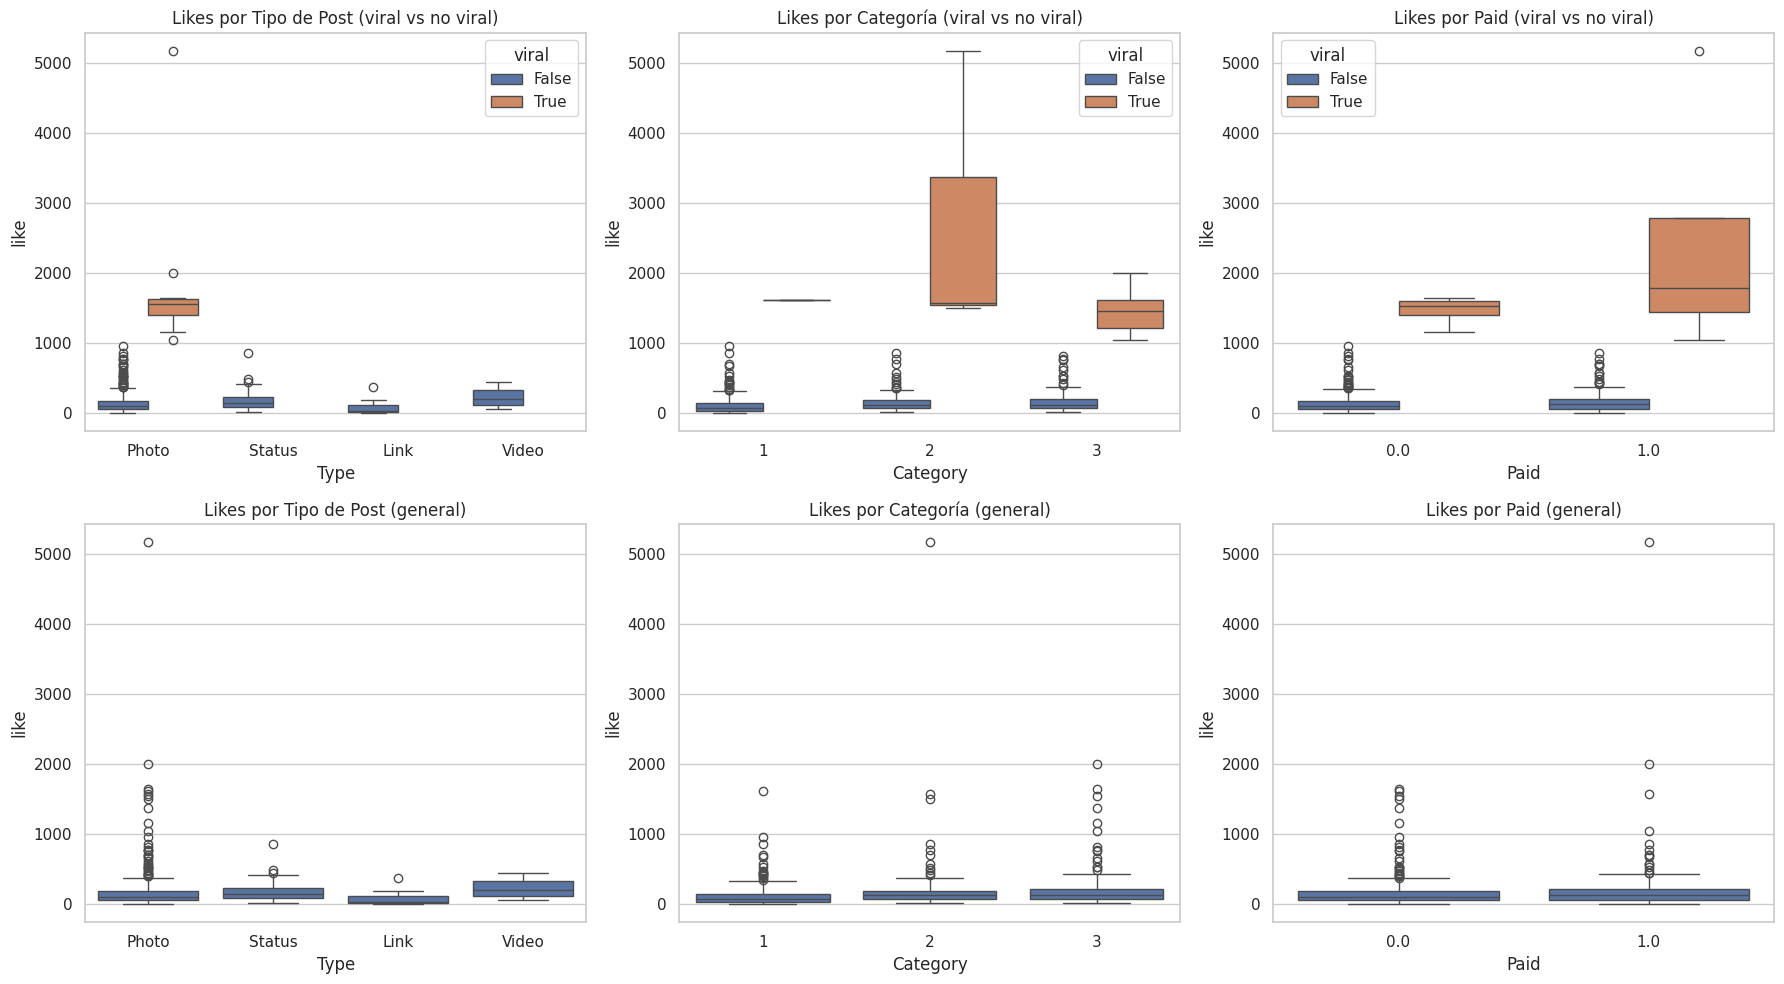

In [239]:
df['viral'] = df['like'] > 1000

fig, axes = plt.subplots(2, 3, figsize=(18,10))

# --- Primera fila: sin hue ---
sns.boxplot(x='Type', y='like', data=df, ax=axes[1,0])
axes[1,0].set_title('Likes por Tipo de Post (general)')

sns.boxplot(x='Category', y='like', data=df, ax=axes[1,1])
axes[1,1].set_title('Likes por Categoría (general)')

sns.boxplot(x='Paid', y='like', data=df, ax=axes[1,2])
axes[1,2].set_title('Likes por Paid (general)')

# --- Segunda fila: con hue='viral' ---
sns.boxplot(x='Type', y='like', hue='viral', data=df, ax=axes[0,0])
axes[0,0].set_title('Likes por Tipo de Post (viral vs no viral)')

sns.boxplot(x='Category', y='like', hue='viral', data=df, ax=axes[0,1])
axes[0,1].set_title('Likes por Categoría (viral vs no viral)')

sns.boxplot(x='Paid', y='like', hue='viral', data=df, ax=axes[0,2])
axes[0,2].set_title('Likes por Paid (viral vs no viral)')


plt.tight_layout()
plt.show()


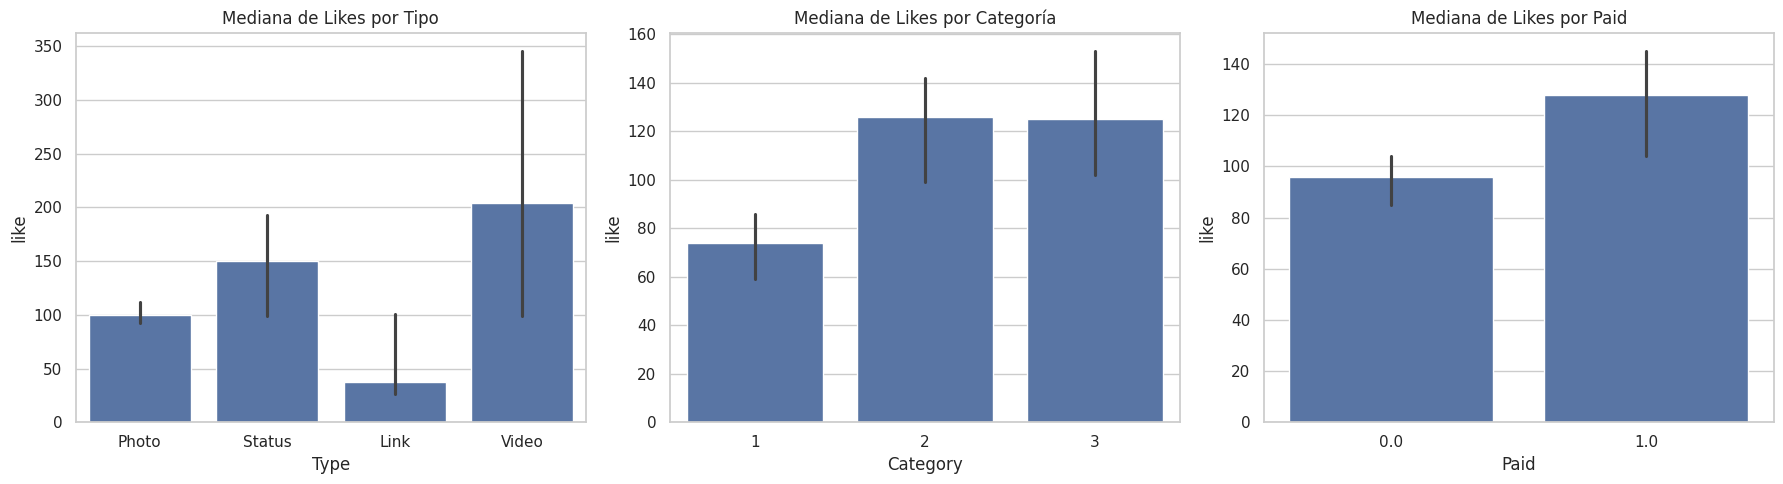

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.barplot(x='Type', y='like', data=df, estimator=np.median, ax=axes[0])
axes[0].set_title('Mediana de Likes por Tipo')

sns.barplot(x='Category', y='like', data=df, estimator=np.median, ax=axes[1])
axes[1].set_title('Mediana de Likes por Categoría')

sns.barplot(x='Paid', y='like', data=df, estimator=np.median, ax=axes[2])
axes[2].set_title('Mediana de Likes por Paid')

plt.tight_layout()
plt.show()


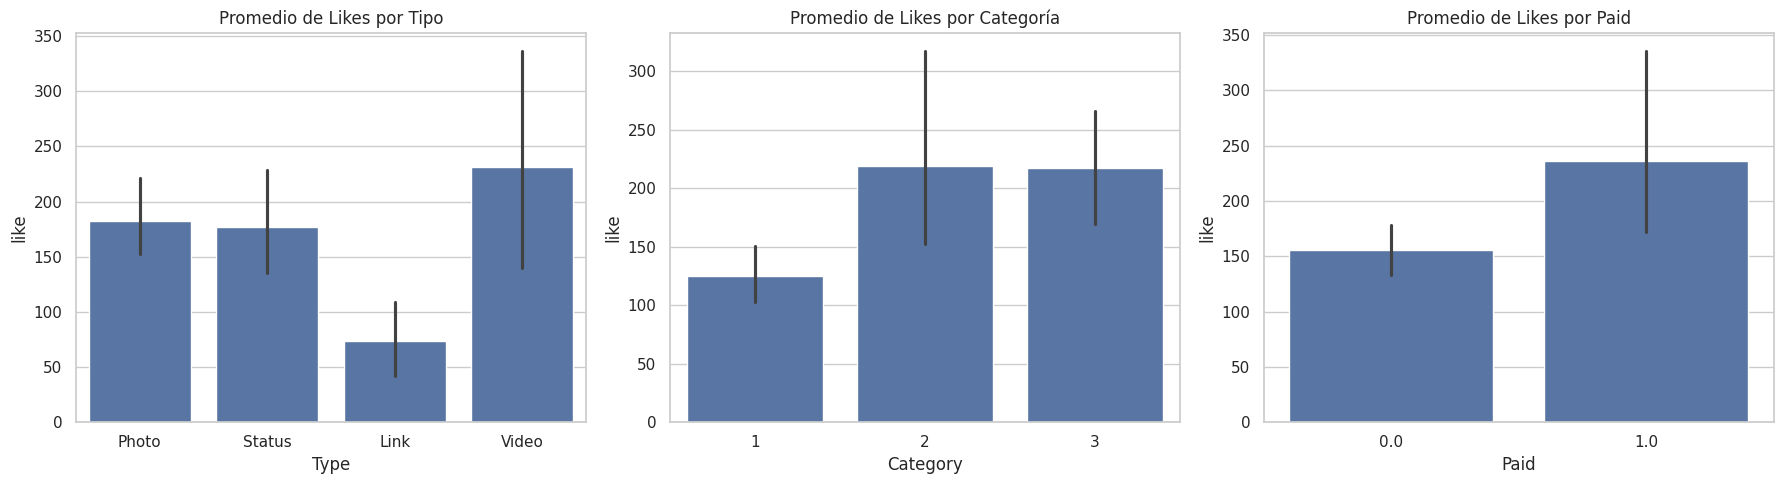

In [241]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.barplot(x='Type', y='like', data=df, estimator=np.mean, ax=axes[0])
axes[0].set_title('Promedio de Likes por Tipo')

sns.barplot(x='Category', y='like', data=df, estimator=np.mean, ax=axes[1])
axes[1].set_title('Promedio de Likes por Categoría')

sns.barplot(x='Paid', y='like', data=df, estimator=np.mean, ax=axes[2])
axes[2].set_title('Promedio de Likes por Paid')

plt.tight_layout()
plt.show()


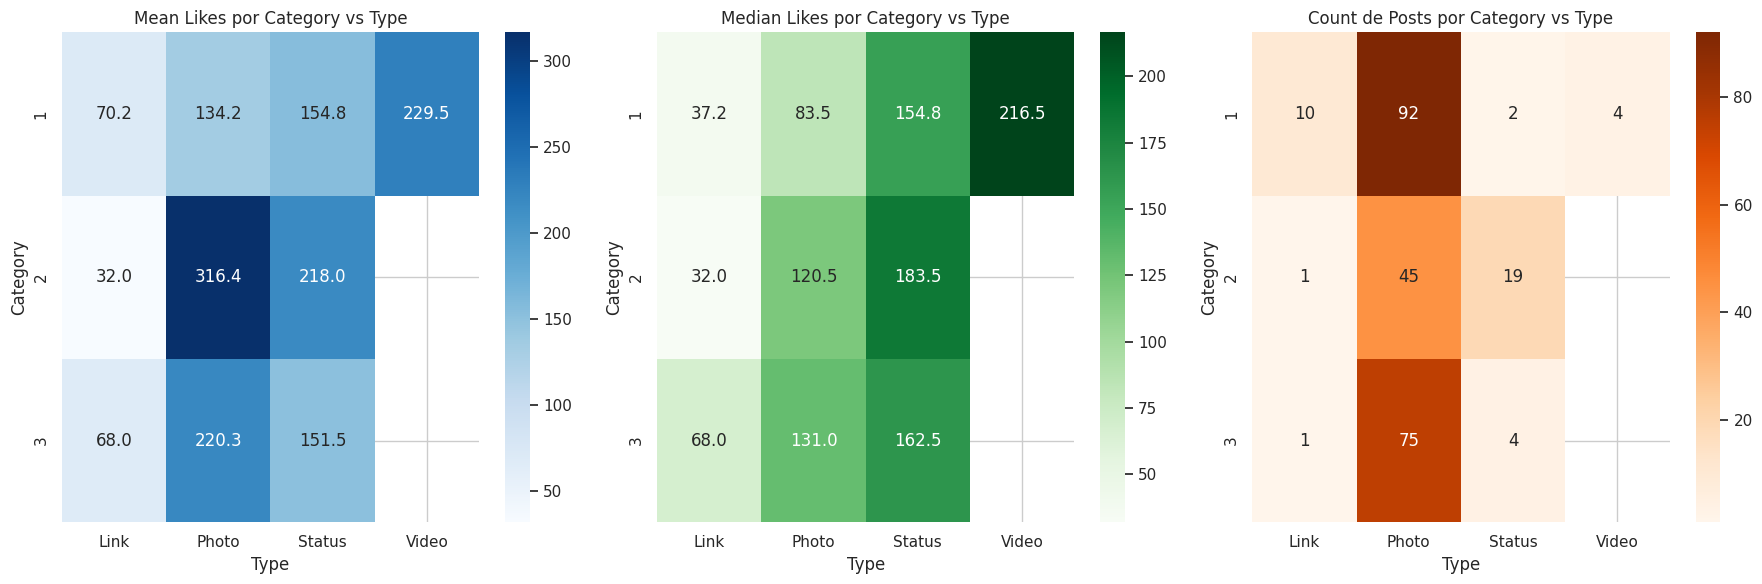

In [242]:
# Resumen agrupado
summary = df.groupby(['Type','Category','Paid'])['like'].agg(['mean','median','count'])

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Heatmap de mean
sns.heatmap(
    summary.pivot_table(values='mean', index='Category', columns='Type'),
    annot=True, fmt=".1f", cmap="Blues", ax=axes[0]
)
axes[0].set_title('Mean Likes por Category vs Type')

# Heatmap de median
sns.heatmap(
    summary.pivot_table(values='median', index='Category', columns='Type'),
    annot=True, fmt=".1f", cmap="Greens", ax=axes[1]
)
axes[1].set_title('Median Likes por Category vs Type')

# Heatmap de count
sns.heatmap(
    summary.pivot_table(values='count', index='Category', columns='Type'),
    annot=True, fmt=".0f", cmap="Oranges", ax=axes[2]
)
axes[2].set_title('Count de Posts por Category vs Type')

plt.tight_layout()
plt.show()



In [243]:
# Definir viral
df['viral'] = df['like'] > 1000

# Calcular % de virales por categoría
viral_pct = (
    df.groupby('Type')['viral']
      .mean() * 100
).sort_values(ascending=False)

print("Porcentaje de casos virales por categoría:")
print(viral_pct)


Porcentaje de casos virales por categoría:
Type
Photo     2.347418
Link      0.000000
Status    0.000000
Video     0.000000
Name: viral, dtype: float64


##### 2. Features de Tiempo

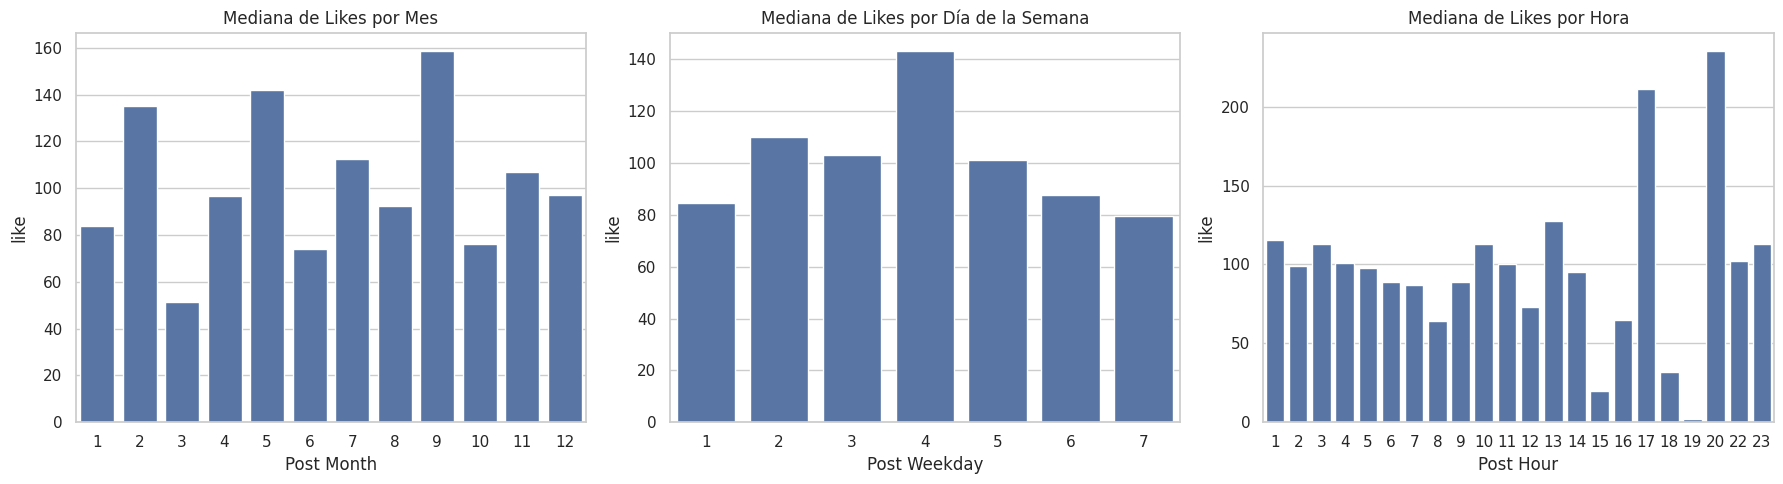

In [244]:

# Todos los types

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Mediana de Likes por Mes
sns.barplot(x='Post Month', y='like', data=df, estimator='median', ax=axes[0],errorbar=None)
axes[0].set_title('Mediana de Likes por Mes')

# Mediana de Likes por Día de la Semana
sns.barplot(x='Post Weekday', y='like', data=df, estimator='median', ax=axes[1],errorbar=None)
axes[1].set_title('Mediana de Likes por Día de la Semana')

# Mediana de Likes por Hora
sns.barplot(x='Post Hour', y='like', data=df, estimator='median', ax=axes[2],errorbar=None)
axes[2].set_title('Mediana de Likes por Hora')

plt.tight_layout()
plt.show()



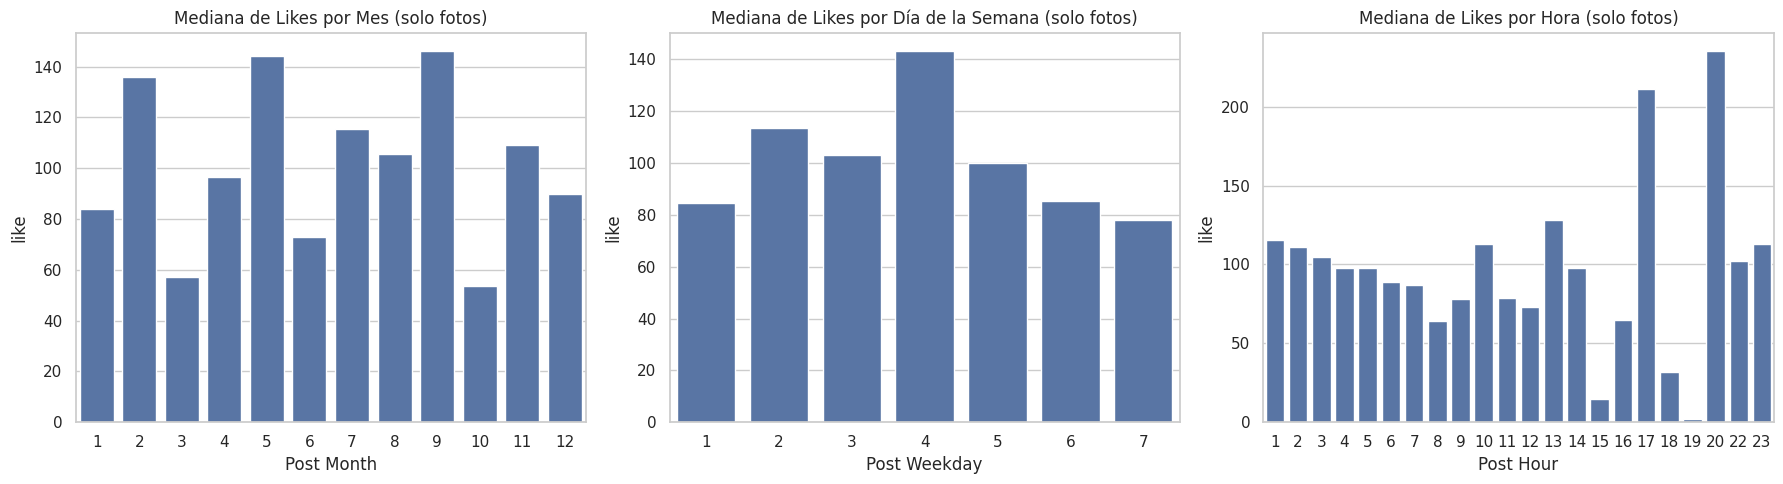

In [245]:
# Filtrar solo publicaciones de tipo Foto
df_photos = df[df['Type'] == 'Photo'].copy()

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Mediana de Likes por Mes (solo fotos)
sns.barplot(x='Post Month', y='like', data=df_photos, estimator='median', ax=axes[0], errorbar=None)
axes[0].set_title('Mediana de Likes por Mes (solo fotos)')

# Mediana de Likes por Día de la Semana (solo fotos)
sns.barplot(x='Post Weekday', y='like', data=df_photos, estimator='median', ax=axes[1], errorbar=None)
axes[1].set_title('Mediana de Likes por Día de la Semana (solo fotos)')

# Mediana de Likes por Hora (solo fotos)
sns.barplot(x='Post Hour', y='like', data=df_photos, estimator='median', ax=axes[2], errorbar=None)
axes[2].set_title('Mediana de Likes por Hora (solo fotos)')

plt.tight_layout()
plt.show()


In [246]:
print("Casos por Mes:")
print(df['Post Month'].value_counts().sort_index())

print("\nCasos por Día de la Semana:")
print(df['Post Weekday'].value_counts().sort_index())

print("\nCasos por Hora:")
print(df['Post Hour'].value_counts().sort_index())


Casos por Mes:
Post Month
1     25
2     26
3     36
4     50
5     37
6     49
7     52
8     34
9     36
10    60
11    45
12    50
Name: count, dtype: int64

Casos por Día de la Semana:
Post Weekday
1    68
2    66
3    64
4    72
5    67
6    81
7    82
Name: count, dtype: int64

Casos por Hora:
Post Hour
1       4
2      39
3     105
4      35
5      13
6      16
7      13
8      12
9      30
10     78
11     44
12     29
13     52
14     13
15      6
16      1
17      3
18      3
19      1
20      1
22      1
23      1
Name: count, dtype: int64


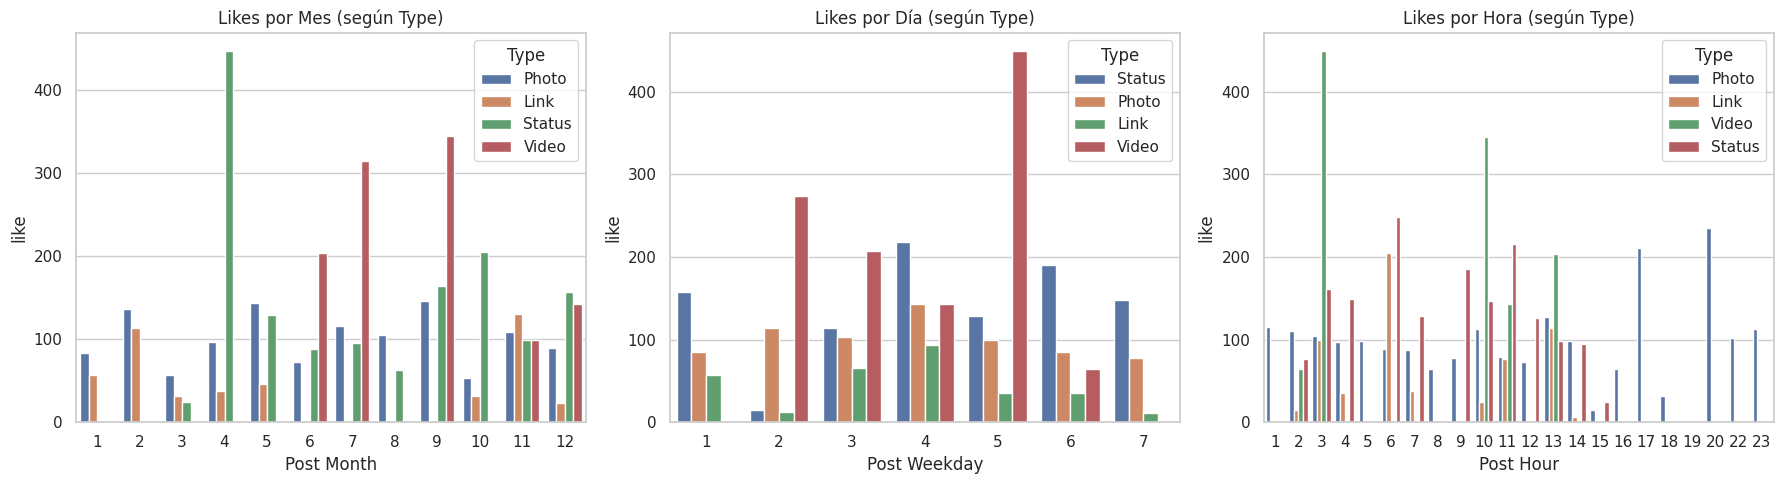

In [247]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Promedio de Likes por Mes con Type
sns.barplot(x='Post Month', y='like', hue='Type', data=df, estimator='median', ax=axes[0], errorbar=None)
axes[0].set_title('Likes por Mes (según Type)')

# Promedio de Likes por Día de la Semana con Type
sns.barplot(x='Post Weekday', y='like', hue='Type', data=df, estimator='median', ax=axes[1], errorbar=None)
axes[1].set_title('Likes por Día (según Type)')

# Promedio de Likes por Hora con Type
sns.barplot(x='Post Hour', y='like', hue='Type', data=df, estimator='median', ax=axes[2], errorbar=None)
axes[2].set_title('Likes por Hora (según Type)')

plt.tight_layout()
plt.show()


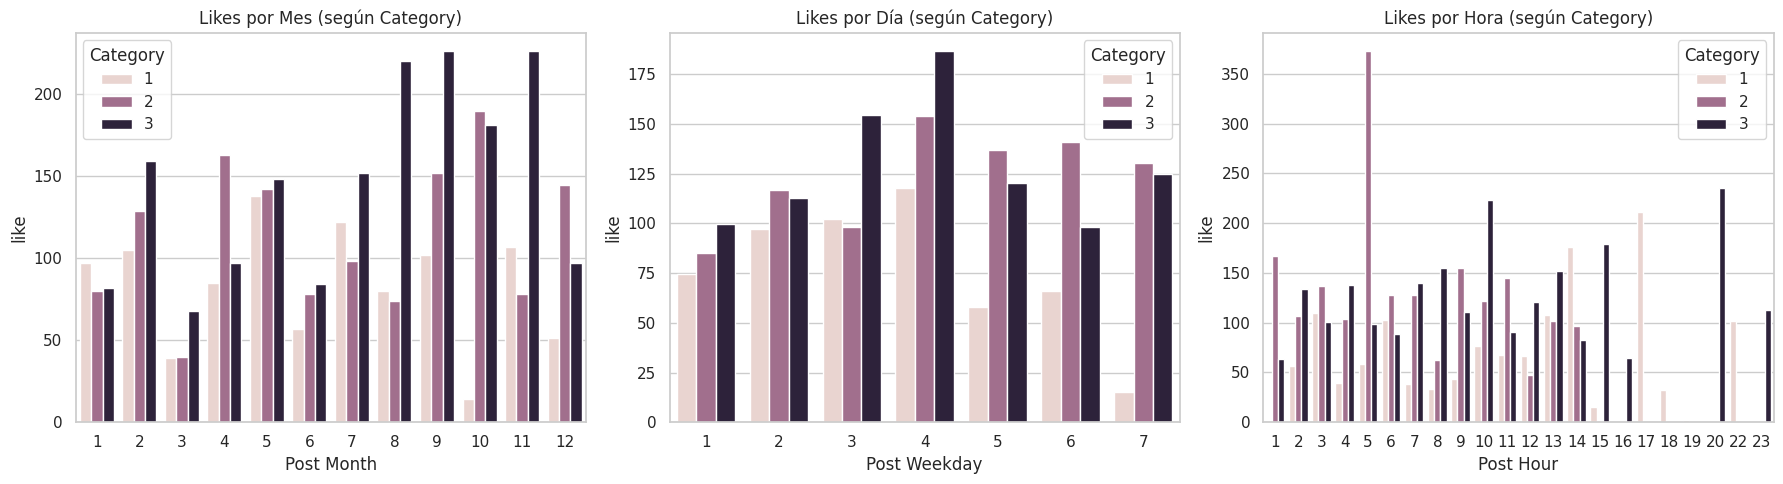

In [248]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Promedio de Likes por Mes con Category
sns.barplot(x='Post Month', y='like', hue='Category', data=df, estimator='median', ax=axes[0], errorbar=None)
axes[0].set_title('Likes por Mes (según Category)')

# Promedio de Likes por Día de la Semana con Category
sns.barplot(x='Post Weekday', y='like', hue='Category', data=df, estimator='median', ax=axes[1], errorbar=None)
axes[1].set_title('Likes por Día (según Category)')

# Promedio de Likes por Hora con Category
sns.barplot(x='Post Hour', y='like', hue='Category', data=df, estimator='median', ax=axes[2], errorbar=None)
axes[2].set_title('Likes por Hora (según Category)')

plt.tight_layout()
plt.show()


#### Variables de Lifetime

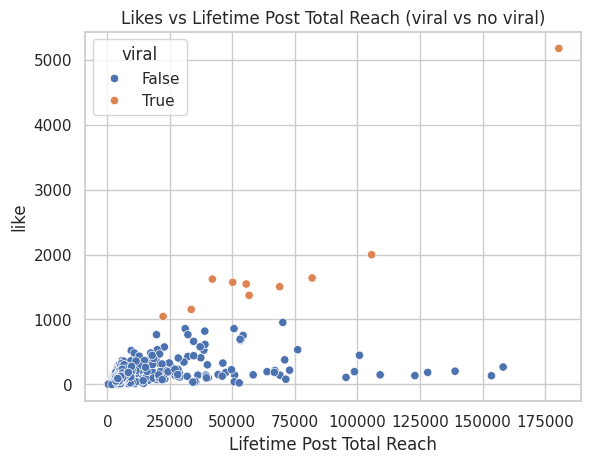

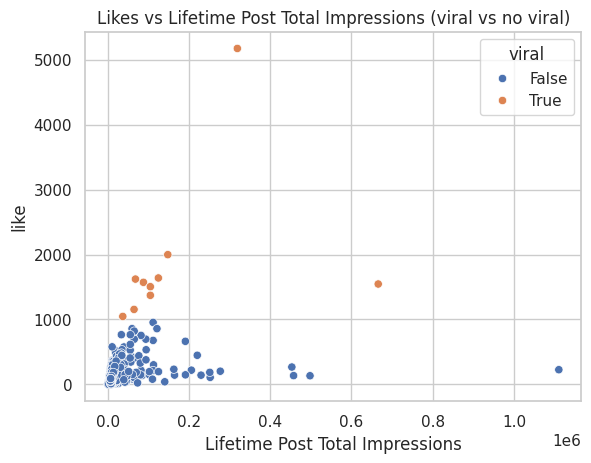

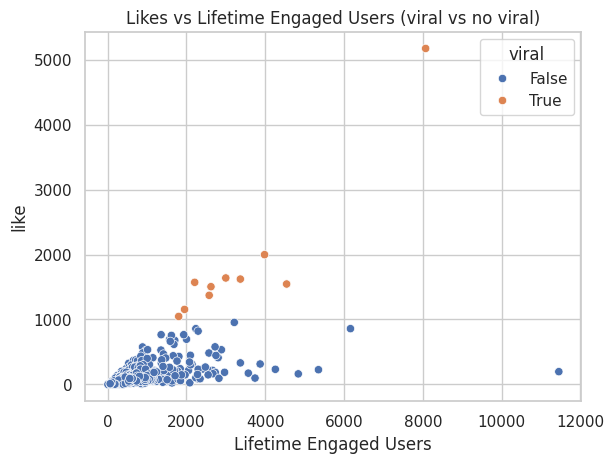

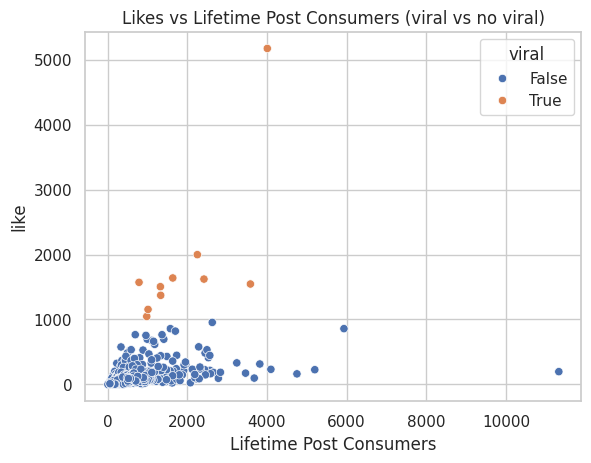

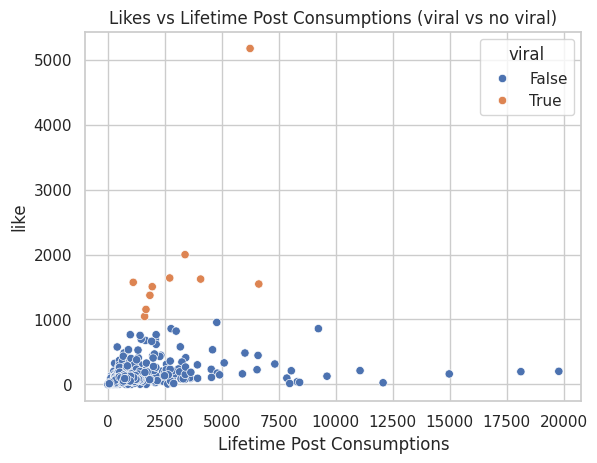

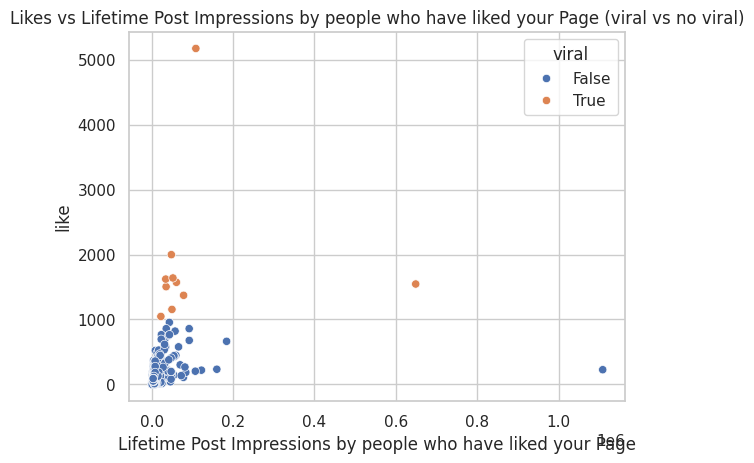

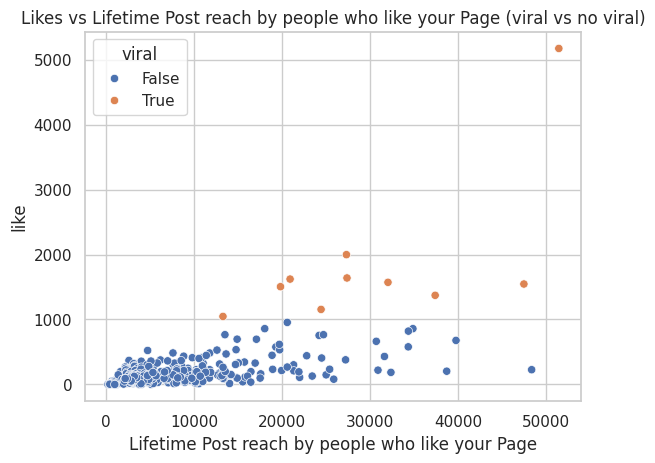

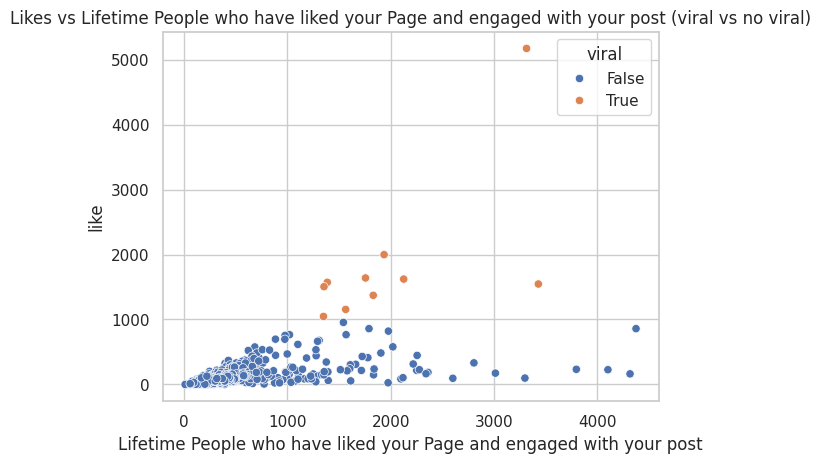

In [249]:
lifetime_vars = [
    'Lifetime Post Total Reach',
    'Lifetime Post Total Impressions',
    'Lifetime Engaged Users',
    'Lifetime Post Consumers',
    'Lifetime Post Consumptions',
    'Lifetime Post Impressions by people who have liked your Page',
    'Lifetime Post reach by people who like your Page',
    'Lifetime People who have liked your Page and engaged with your post'
]

for var in lifetime_vars:
    sns.scatterplot(x=var, y='like', hue='viral', data=df)
    plt.title(f'Likes vs {var} (viral vs no viral)')
    plt.show()


#### Interacciones

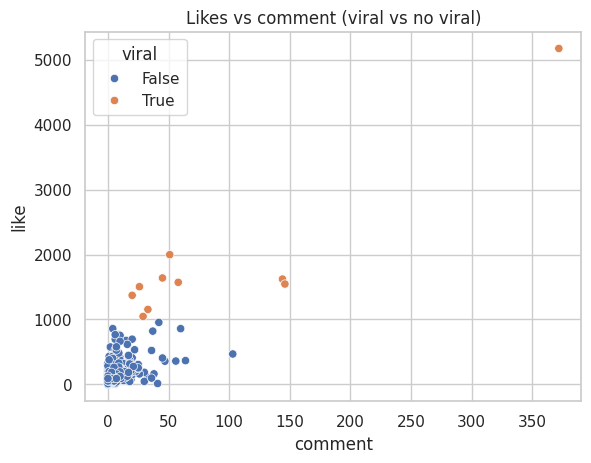

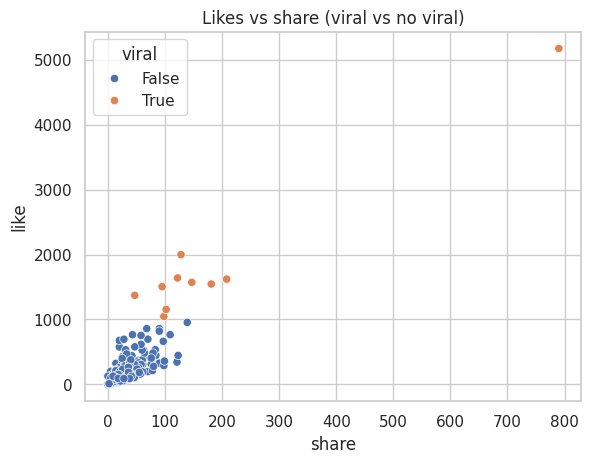

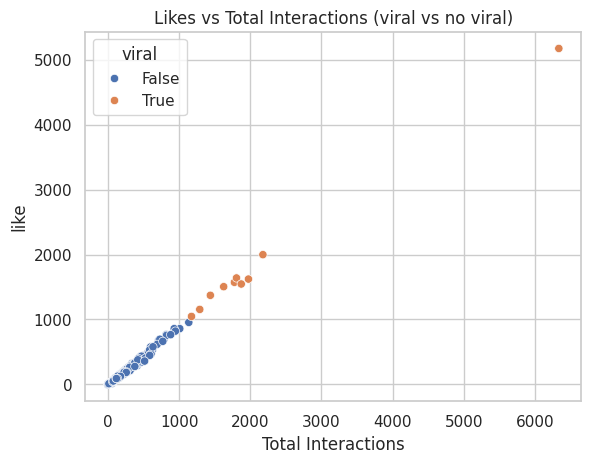

In [250]:
interaction_vars = ['comment', 'share', 'Total Interactions']

for var in interaction_vars:
    sns.scatterplot(x=var, y='like', hue='viral', data=df)
    plt.title(f'Likes vs {var} (viral vs no viral)')
    plt.show()


#### Matriz de Correlaciones

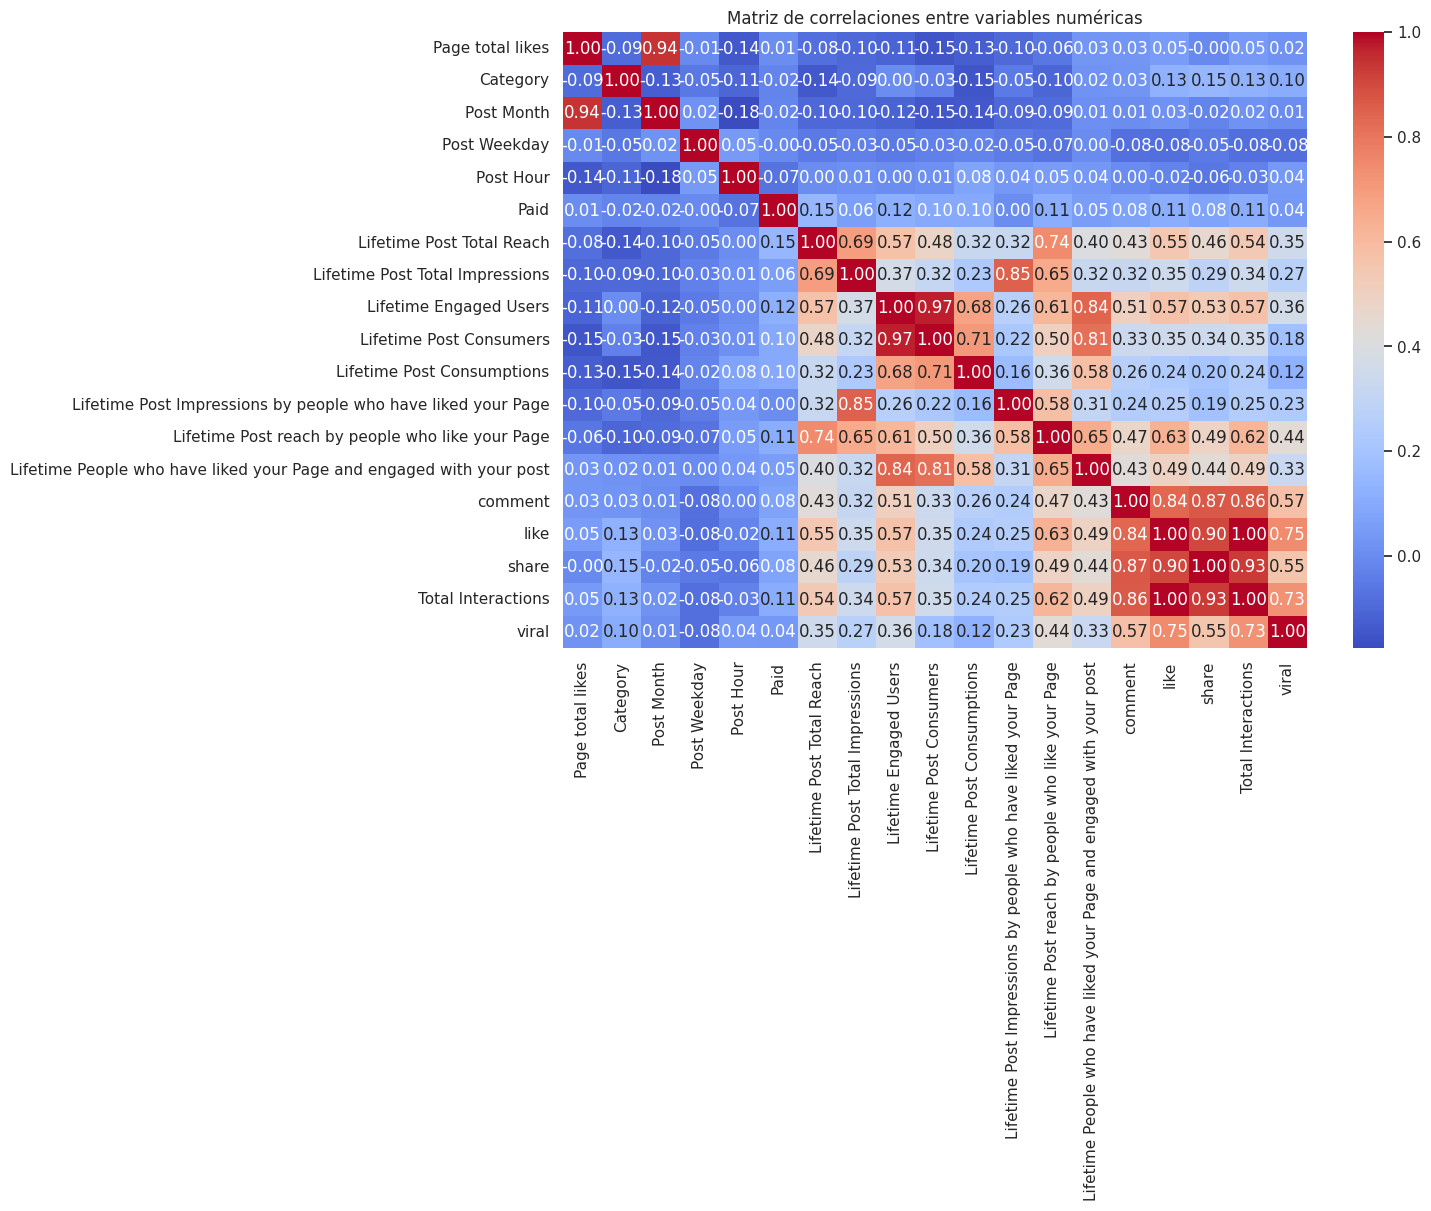

In [251]:
# --- Matriz de correlaciones ---
corr_matrix = df.corr(numeric_only=True)  # solo columnas numéricas

# --- Heatmap ---
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlaciones entre variables numéricas")
plt.show()


## 3. Preprocess

### 3.1 Nulos

##### 3.1.1 NA en Target

In [252]:
# No nos sirven registros sin target
target_na = df['like'].isna().sum()
print(f"\n🎯 Registros con 'like' nulo: {target_na}")
df_clean = df.dropna(subset=['like']).copy()

# chequeo rápido
print(df_clean.isna().sum())



🎯 Registros con 'like' nulo: 1
Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach

##### 3.1.2 NA en Paid

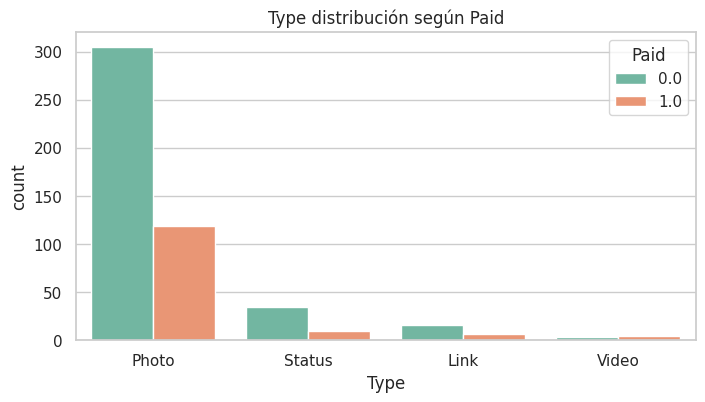

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [253]:
# --- Análisis de registros nulos en features nulos ---

# Nulo en 'Paid'

num_cols = df_clean.select_dtypes(include=['int64','float64']).columns

# for col in num_cols:
#     plt.figure(figsize=(8,4))
#     sns.boxplot(x='Paid', y=col, data=df_clean, palette='Set2')
#     sns.stripplot(x='Paid', y=col, data=df_clean[df_clean['Paid'].isna()],
#                   color='red', marker='x', size=8, label='NA')
#     plt.title(f"{col} vs Paid (0/1/NA)")
#     plt.legend()
#     plt.show()

# # Variables categóricas
# cat_cols = df_clean.select_dtypes(include=['object']).columns

# for col in cat_cols:
#     plt.figure(figsize=(8,4))
#     sns.countplot(x=col, hue='Paid', data=df_clean, palette='Set2')
#     plt.title(f"{col} distribución según Paid")
#     plt.show()



plt.figure(figsize=(8,4))
sns.countplot(x='Type', hue='Paid', data=df_clean, palette='Set2')
plt.title(f"Type distribución según Paid")
plt.show()

# Dado que su type es "Photo", podemos inferir que es un post no pago

df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'] = df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'].fillna(0)

print(df_clean.isna().sum())



##### 3.1.3 NAs en share

In [254]:
# Chequeo de q para todos los registros sin NA se cumple que Total Interactions = comment + like + share

df_no_na = df_clean.dropna(subset=["Total Interactions", "comment", "like", "share"]).copy()

df_no_na["check_interactions"] = (
    df_no_na["Total Interactions"] == df_no_na["comment"] + df_no_na["like"] + df_no_na["share"]
)


# Verificamos si todos cumplen
all_good = df_no_na["check_interactions"].all()

print("¿Todos los registros cumplen la condición?", all_good)


¿Todos los registros cumplen la condición? True


In [255]:
# Imputo share

# Imputar valores faltantes en 'share' usando la relación validada
df_clean.loc[df_clean["share"].isna(), "share"] = (
    df_clean["Total Interactions"] - df_clean["comment"] - df_clean["like"]
)

# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean["share"].isna().sum())


0


In [256]:
# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean.isna().sum())

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [257]:
# elimino la variable viral
df_clean.drop(columns=['viral'], inplace=True)

### 3.2 Pipeline de Scaler y Dummies

In [258]:
# --- Pipeline de Preprocesamiento
# 1. Definir X e y
y = df_clean['like']
X = df_clean.drop(columns=['like'])

# 2. Función para crear PostHourBin
def bin_post_hour(X):
    X = X.copy()
    bins = [0, 6, 12, 18, 24]
    labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    X['PostHourBin'] = pd.cut(X['Post Hour'], bins=bins, labels=labels, right=False)
    return X

binning_transformer = FunctionTransformer(bin_post_hour, validate=False)

# 3. Definir columnas
numeric_as_category = ['Category','PostHourBin','Post Weekday']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col not in numeric_as_category]
categorical_features = list(X.select_dtypes(include=['object']).columns) + numeric_as_category

# 4. Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

weekday_hour_interactions = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# 5. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        # ('weekday_hour', weekday_hour_interactions, ['Post Weekday','PostHourBin'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)


# Aplicar binning + preprocessor directamente
X_preprocessed = Pipeline(steps=[
    ('binning', binning_transformer),
    ('preprocessor', preprocessor)
]).fit_transform(X)

# Convertir a DataFrame con nombres de columnas
feature_names = preprocessor.get_feature_names_out()
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

print(X_preprocessed.shape)
print(X_preprocessed.head())


(499, 33)
   Page total likes  Post Month  Post Hour  Paid  Lifetime Post Total Reach  \
0          0.408866    0.833333     -0.750   0.0                  -0.256540   
1          0.408866    0.833333      0.125   0.0                   0.525046   
2          0.408866    0.833333     -0.750   0.0                  -0.290915   
3          0.408866    0.833333      0.125   1.0                   4.547353   
4          0.408866    0.833333     -0.750   0.0                   0.198945   

   Lifetime Post Total Impressions  Lifetime Engaged Users  \
0                        -0.241094               -0.672673   
1                         0.605767                1.247748   
2                        -0.284631               -0.674174   
3                         4.785738                2.379880   
4                         0.274505                0.067568   

   Lifetime Post Consumers  Lifetime Post Consumptions  \
0                -0.712570                   -0.726415   
1                 1.292234

# 4. Modelos

## 4.1 Modelos Incluyendo todos los features (todos los types)


#### 4.1.2 RF - Excluyo casos virales en train


In [259]:
# Split primero SIN filtrar
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, df_clean['like'], test_size=0.2, random_state=42
)

# Filtrar solo en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

#Drop de features
features_to_drop = ['Total Interactions']
X_train = X_train.drop(columns=features_to_drop, errors='ignore')
X_test = X_test.drop(columns=features_to_drop, errors='ignore')

# --- Logs de trazabilidad ---
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")
print(f"Casos no virales en test: {(y_test < 1000).sum()}")


Train shape: (392, 32), Test shape: (100, 32)
Casos virales excluidos en train: 7
Casos virales presentes en test: 3
Casos no virales en test: 97


In [260]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 6, 'regressor__max_features': 0.6739816909220269, 'regressor__max_samples': 1.0, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 20})


In [261]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Max Error
max_err_opt = max_error(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")
print(f"Max Error (Mayor error absoluto observado): {max_err_opt:.2f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 65.95
RMSE (Raíz Error Cuadrático): 152.22
R2 Score: 0.5952
Max Error (Mayor error absoluto observado): 929.57


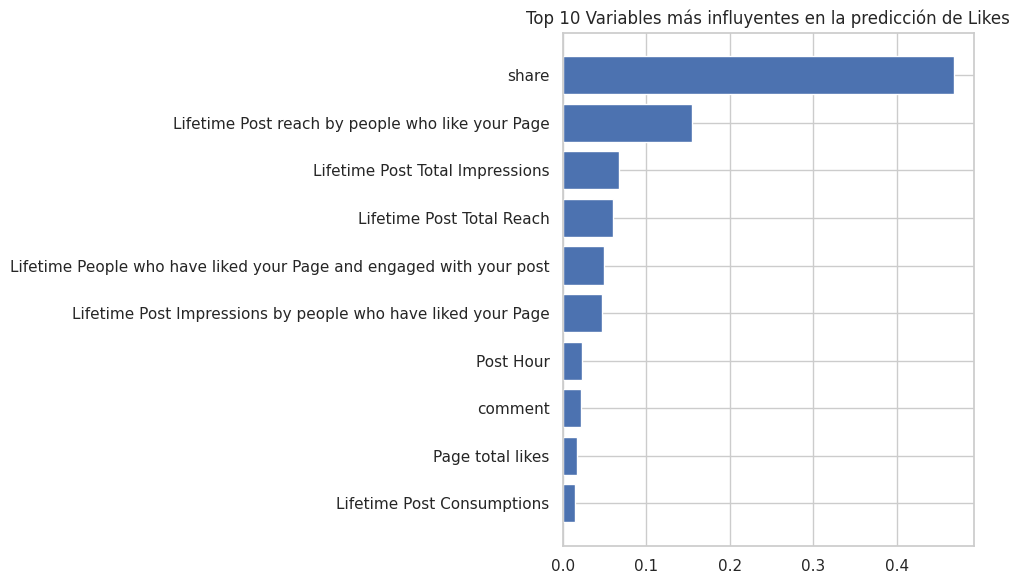

In [262]:

# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']

# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10 en horizontal
plt.figure(figsize=(10, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices[:10]])
plt.gca().invert_yaxis()  # el más importante arriba
plt.tight_layout()

# Guardar en PNG con buena resolución
plt.savefig("feature_importances.png", dpi=300, bbox_inches="tight")
plt.show()


## 4.1 Modelos Incluyendo todos los features (solo fotos)


#### 4.1.2 RF - Excluyo casos virales en train


In [263]:
# --- Filtrar solo fotos ---
df_photos = df_clean[df_clean['Type'] == 'Photo'].copy()

# Split primero SIN filtrar por virales
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed.loc[df_photos.index],  # solo filas de fotos
    df_photos['like'],
    test_size=0.2,
    random_state=42
)

# Filtrar solo en train (excluir virales)
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

# Opcional: drop de features
features_to_drop = ['Total Interactions']
X_train = X_train.drop(columns=features_to_drop, errors='ignore')
X_test = X_test.drop(columns=features_to_drop, errors='ignore')

# --- Logs de trazabilidad ---
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")
print(f"Casos no virales en test: {(y_test < 1000).sum()}")
print(f"Solo fotos incluidas: {df_photos.shape[0]} registros")


Train shape: (330, 32), Test shape: (85, 32)
Casos virales excluidos en train: 10
Casos virales presentes en test: 0
Casos no virales en test: 85
Solo fotos incluidas: 425 registros


In [264]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 13, 'regressor__max_features': 0.8002436910777186, 'regressor__max_samples': 1.0, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150})


In [265]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Max Error
max_err_opt = max_error(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")
print(f"Max Error (Mayor error absoluto observado): {max_err_opt:.2f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 36.73
RMSE (Raíz Error Cuadrático): 67.15
R2 Score: 0.7990
Max Error (Mayor error absoluto observado): 393.41


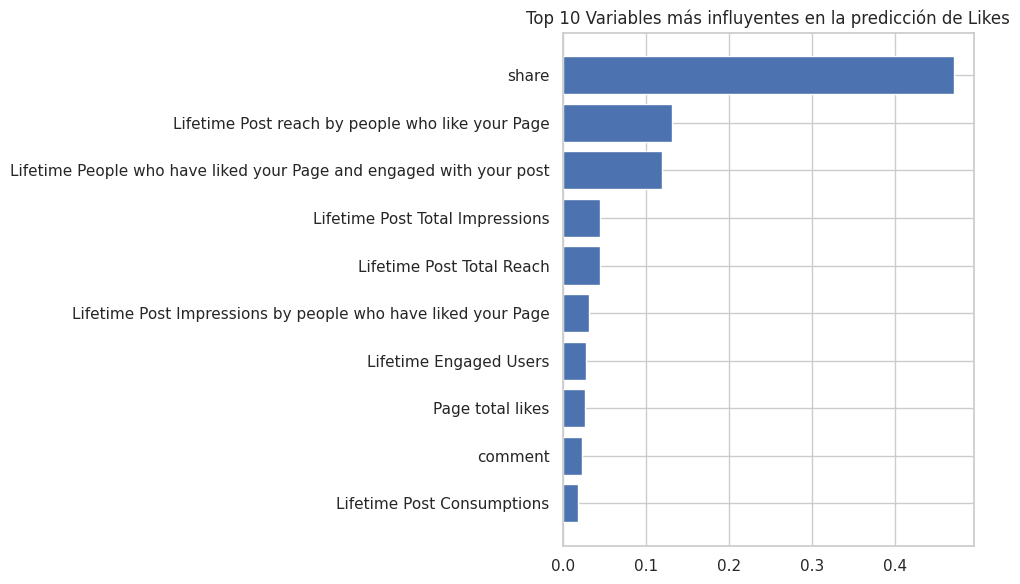

In [266]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']

# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10 en horizontal
plt.figure(figsize=(10, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices[:10]])
plt.gca().invert_yaxis()  # el más importante arriba
plt.tight_layout()

# Guardar en PNG con buena resolución
plt.savefig("feature_importances.png", dpi=300, bbox_inches="tight")
plt.show()


## 4.2 Modelo Excluyendo features con data leakege


#### 4.2.4 RF - Excluyendo casos virales en train

In [267]:
# 1. Selección de Features (leakage eliminados en ambos)
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20 (primero separamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales SOLO en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")

Train shape: (392, 22), Test shape: (100, 22)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 11, 'regressor__max_features': 0.9530075991934837, 'regressor__max_samples': 0.6578997967435244, 'regressor__min_samples_leaf': 7, 'regressor__min_samples_split': 9, 'regressor__n_estimators': 66})


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# MAPE (Mean Absolute Percentage Error)
mape_opt = np.mean(np.abs((y_test - y_pred_opt) / y_test)) * 100

# Max Error
max_err_opt = max_error(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")
print(f"MAPE (Error Absoluto Medio en %): {mape_opt:.2f}%")
print(f"Max Error (Mayor error absoluto observado): {max_err_opt:.2f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 124.46
RMSE (Raíz Error Cuadrático): 233.81
R2 Score: 0.0450
MAPE (Error Absoluto Medio en %): inf%
Max Error (Mayor error absoluto observado): 1277.30


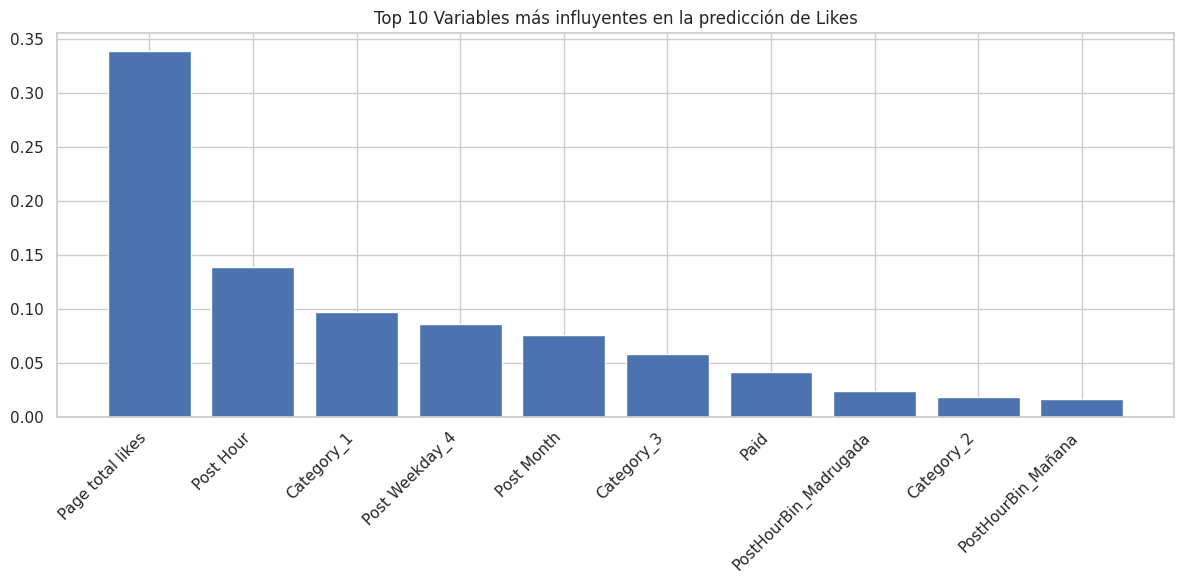

In [ ]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Modelos Testeados (Archivo)

## 4.1 Modelos Incluyendo todos los features


#### 4.1.1 RF - Todos los casos

In [129]:
# 1. Selección de Features

features_to_drop = ['Total Interactions']
X = X_preprocessed.drop(columns=features_to_drop)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 33), Test shape: (100, 33)


In [130]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 13, 'regressor__max_features': 1.0, 'regressor__max_samples': 0.7678623351484586, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 20})


In [131]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 62.23
RMSE (Raíz Error Cuadrático): 127.78
R2 Score: 0.7147


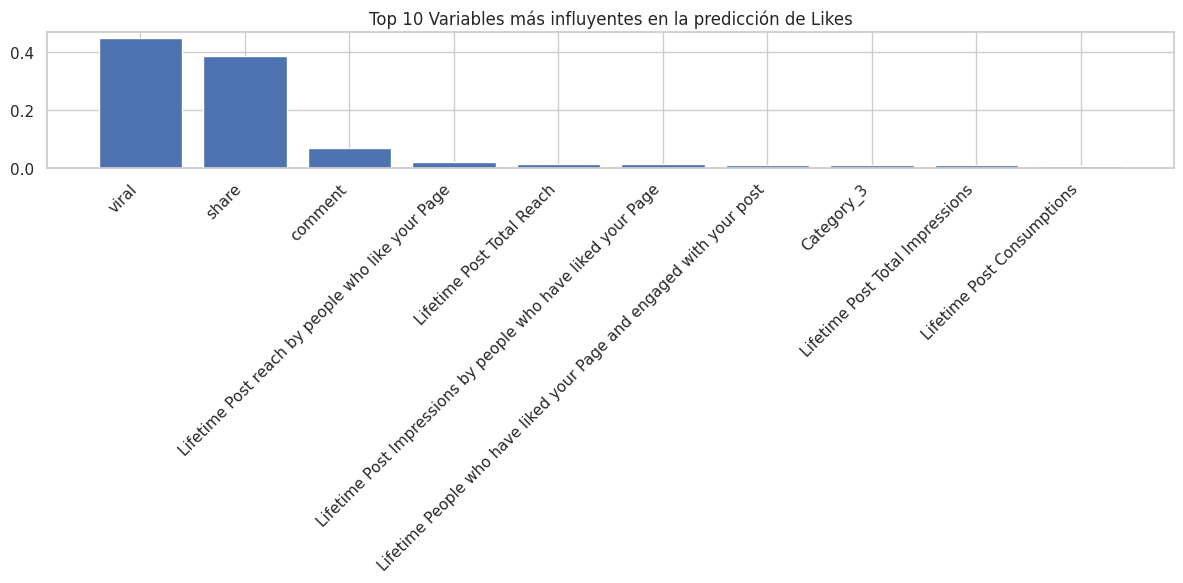

In [132]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']


# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.1.3 KNN - Todos los casos

In [133]:
# 1. Selección de Features

features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 2), Test shape: (100, 2)


In [134]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),
    'regressor__weights': Categorical(['distance']),
    'regressor__p': Integer(1, 2)
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(26), np.int64(1), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(7), np.int64(1), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(13), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(13),

Mejores hiperparámetros KNN: OrderedDict({'regressor__n_neighbors': 4, 'regressor__p': 1, 'regressor__weights': 'distance'})


In [135]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 74.87
RMSE (Raíz Error Cuadrático): 175.69
R2 Score: 0.4607


#### 4.1.2 KNN - Excluyo casos virales en train

In [136]:
# --- Selección de Features ---
features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# --- Split 80-20  ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Filtro solo en Train ---
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train]

print(f"Train shape (filtrado): {X_train.shape}, Test shape (sin filtrar): {X_test.shape}")


Train shape (filtrado): (392, 2), Test shape (sin filtrar): (100, 2)


In [138]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),
    'regressor__weights': Categorical(['distance']),
    'regressor__p': Integer(1, 2)   }

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(24), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(9), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(28), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(11),

Mejores hiperparámetros KNN: OrderedDict({'regressor__n_neighbors': 8, 'regressor__p': 2, 'regressor__weights': 'distance'})


In [139]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 79.00
RMSE (Raíz Error Cuadrático): 186.72
R2 Score: 0.3909


## 4.2 Modelos Excluyendo features con data leakege


#### 4.2.1 Linear Regression (Ridge) - Todos los casos

In [140]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [141]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 200, prior='log-uniform')
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__alpha': 1.9226953989206237})


In [142]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 100.47
RMSE (Raíz Error Cuadrático): 144.60
R2 Score: 0.6347


In [143]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']

coef = lr.coef_
intercept = lr.intercept_


feature_names = X_train.columns

import pandas as pd
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))


                  feature  coefficient
22                  viral  1509.470773
11  PostHourBin_Madrugada    65.598270
7              Type_Video    56.901443
0        Page total likes    52.316630
4               Type_Link   -51.061565
3                    Paid    49.802158
13      PostHourBin_Noche   -39.127859
1              Post Month   -38.177862
8              Category_1   -37.006108
2               Post Hour    32.043843
17         Post Weekday_3    30.282251
9              Category_2    24.550702
15         Post Weekday_1   -22.129011
18         Post Weekday_4    16.558257
21         Post Weekday_7   -15.089893
12     PostHourBin_Mañana   -13.292253
14      PostHourBin_Tarde   -13.178158
20         Post Weekday_6   -12.653664
10             Category_3    12.455406
5              Type_Photo    -4.474739


#### 4.2.2 Linear Regression (ridge) - Excluyo casos virales en train

In [144]:
# 1. Selección de Features
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales solo en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")


Train shape: (392, 23), Test shape: (100, 23)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [145]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 200, prior='log-uniform')
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__alpha': 39.738369959216605})


In [146]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 126.42
RMSE (Raíz Error Cuadrático): 235.24
R2 Score: 0.0332


In [148]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']

coef = lr.coef_
intercept = lr.intercept_

feature_names = X_train.columns

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))


                  feature  coefficient
18         Post Weekday_4    24.965375
8              Category_1   -23.558291
10             Category_3    22.312399
4               Type_Link   -19.500847
17         Post Weekday_3   -14.527204
0        Page total likes    13.942055
6             Type_Status    13.543144
3                    Paid    12.549540
7              Type_Video    11.302164
2               Post Hour   -11.004371
15         Post Weekday_1   -10.139814
11  PostHourBin_Madrugada     8.631768
12     PostHourBin_Mañana    -8.098826
1              Post Month     7.749165
16         Post Weekday_2     7.507940
21         Post Weekday_7    -7.166980
20         Post Weekday_6    -6.551126
19         Post Weekday_5     5.911808
5              Type_Photo    -5.344462
13      PostHourBin_Noche    -1.764536


#### 4.2.3 RF - Todos los casos

In [149]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [150]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 15, 'regressor__max_features': 1.0, 'regressor__max_samples': 0.6189040107097356, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 150})


In [151]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 113.79
RMSE (Raíz Error Cuadrático): 175.71
R2 Score: 0.4606


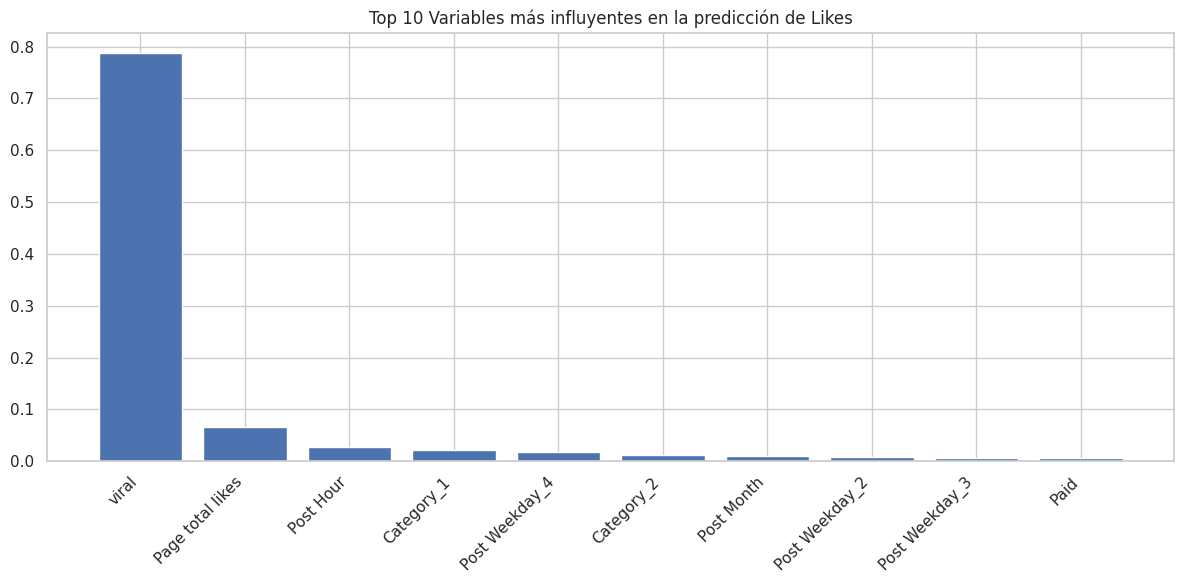

In [152]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']

# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.2.5 XGBoost - Todos los casos

In [153]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [154]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 300),
    'regressor__max_depth': Integer(2, 15),
    'regressor__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'regressor__subsample': Real(0.5, 1.0),
    'regressor__colsample_bytree': Real(0.5, 1.0),
}

# Pipeline SOLO con XGBoost
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__colsample_bytree': 0.8070499004889022, 'regressor__learning_rate': 0.02062603634082244, 'regressor__max_depth': 3, 'regressor__n_estimators': 186, 'regressor__subsample': 0.781946142065338})


In [155]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 137.35
RMSE (Raíz Error Cuadrático): 326.59
R2 Score: -0.8634


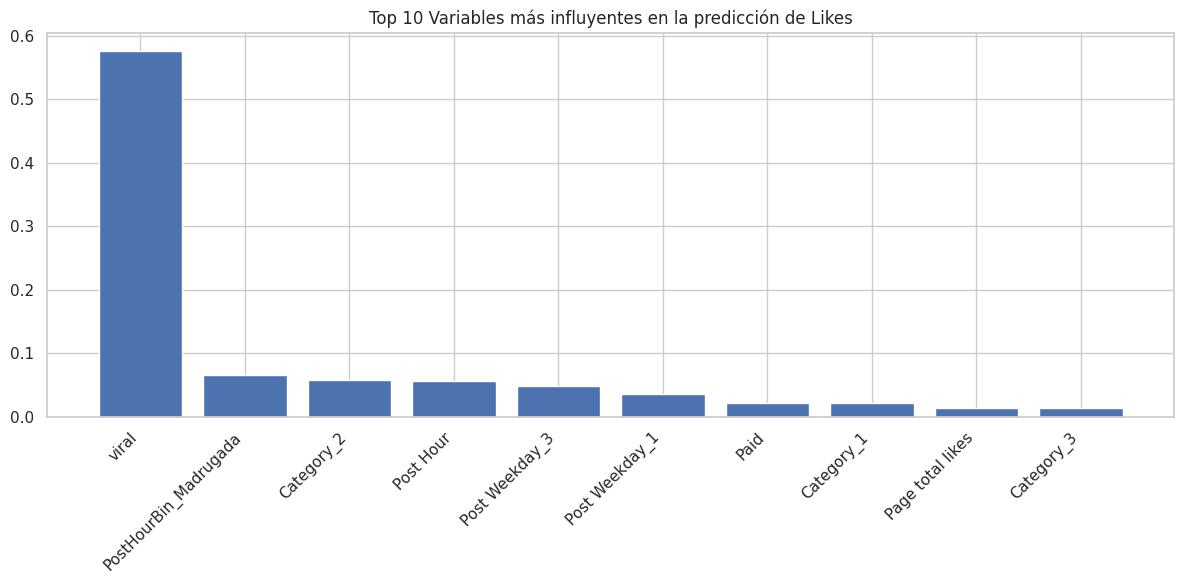

In [156]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']


# Importancias
importances = rf_model.feature_importances_

# Nombres de features
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.2.3 XGBoost - Excluyendo casos virales en train

In [157]:
# 1. Selección de Features (leakage eliminados en ambos)
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20 (primero separamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales solo en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")


Train shape: (392, 23), Test shape: (100, 23)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [158]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 300),
    'regressor__max_depth': Integer(2, 15),
    'regressor__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'regressor__subsample': Real(0.5, 1.0),
    'regressor__colsample_bytree': Real(0.5, 1.0),
}

# Pipeline
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5, 0.01, np.int64(15), np.int64(50), 1.0] before, using random point [0.8020448175185674, 0.01814795489287731, np.int64(11), np.int64(166), 0.769846161762038]
  warnings.warn(


Mejores hiperparámetros: OrderedDict({'regressor__colsample_bytree': 0.5, 'regressor__learning_rate': 0.01588038358841875, 'regressor__max_depth': 15, 'regressor__n_estimators': 50, 'regressor__subsample': 0.7404054653859873})


In [159]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 126.77
RMSE (Raíz Error Cuadrático): 236.98
R2 Score: 0.0188


Número total de features usadas en el entrenamiento: 34
Listado de features finales:
0: Page total likes
1: Post Month
2: Post Hour
3: Paid
4: Lifetime Post Total Reach
5: Lifetime Post Total Impressions
6: Lifetime Engaged Users
7: Lifetime Post Consumers
8: Lifetime Post Consumptions
9: Lifetime Post Impressions by people who have liked your Page
10: Lifetime Post reach by people who like your Page
11: Lifetime People who have liked your Page and engaged with your post
12: comment
13: share
14: Total Interactions
15: Type_Link
16: Type_Photo
17: Type_Status
18: Type_Video
19: Category_1
20: Category_2
21: Category_3
22: PostHourBin_Madrugada
23: PostHourBin_Mañana
24: PostHourBin_Noche
25: PostHourBin_Tarde
26: Post Weekday_1
27: Post Weekday_2
28: Post Weekday_3
29: Post Weekday_4
30: Post Weekday_5
31: Post Weekday_6
32: Post Weekday_7
33: viral


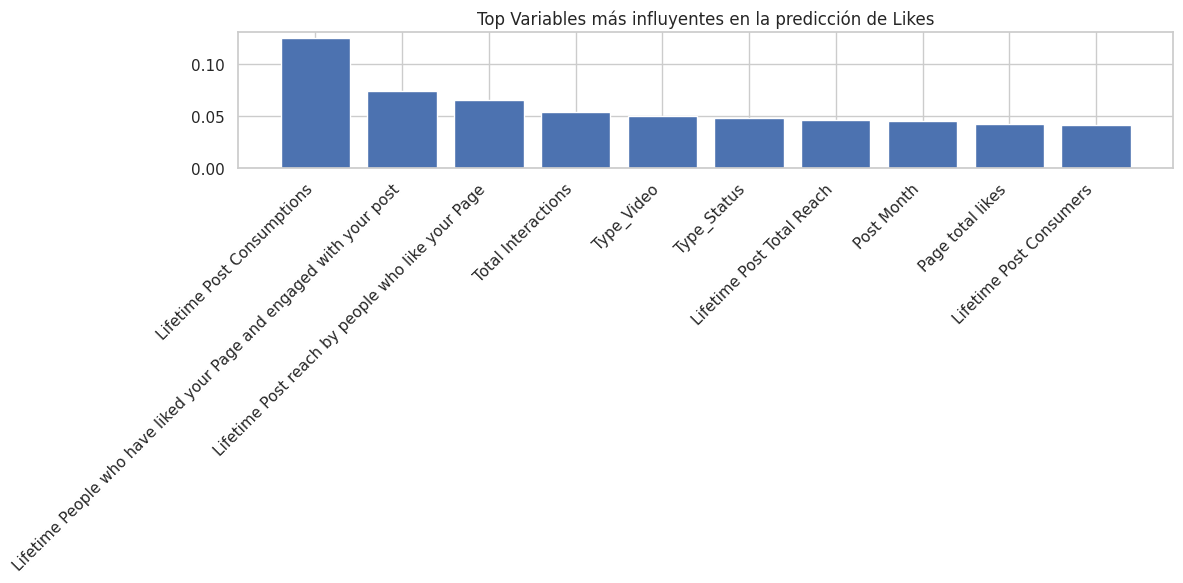

In [160]:
# Acceder al modelo entrenado
rf = best_model.named_steps['regressor']


# Paso 1: nombres de features desde X_preprocessed
feature_names = X_preprocessed.columns

print(f"Número total de features usadas en el entrenamiento: {len(feature_names)}")
print("Listado de features finales:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

# Paso 2: importancias
importances = rf.feature_importances_

# Paso 3: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.figure(figsize=(12, 6))
plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()
